In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from data_reading import read_and_combine_csv
from feature_engineering import FeatureEngineeringRL
from config import Config

config = Config()
fe = FeatureEngineeringRL()
fold_name = f'{config.symbols[7]}-spot-klines-15m-from_2018_to_2025'
df = read_and_combine_csv(f'./raw_data/{fold_name}')

正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2022-08.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2025-01.csv
读取文件失败: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2025-01.csv, 错误: year 56971 is out of range
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2018-09.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2018-08.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2022-09.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2020-08.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2020-09.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2019-02.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2021-06.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2021-12.csv
正在读取文件: ./raw_data/ETHUSDT-spot-k

In [50]:
df = fe.process_data(df)
df.drop(['Open time', 'Close time', 'Ignore'], axis=1, inplace=True)
df.dropna(inplace=True)

In [51]:
import numpy as np
import gym
from gym import spaces

class CryptoTradingEnv(gym.Env):
    def __init__(self, df, initial_balance=10000, fee_rate=0.001):
        super(CryptoTradingEnv, self).__init__()
        
        self.df = df
        self.initial_balance = initial_balance
        self.fee_rate = fee_rate  # 0.1% per trade
        self.current_step = 0

        # Trading states
        self.balance = self.initial_balance
        self.position = 0  # Positive for long, negative for short
        self.entry_price = 0  # Entry price for current position
        
        # Select Features
        self.feature_columns = [
            'Open', 'High', 'Low', 'Close', 'Volume',
            'Quote asset volume', 'Number of trades', 
            'Taker buy base asset volume', 'Taker buy quote asset volume',
            'MACD', 'RSI', 'VWAP', 'BB_MIDDLE', 'BB_UPPER', 'BB_LOWER'
        ]
        
        # Update observation space
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(len(self.feature_columns),), dtype=np.float32)
        
        # Define action space: 0 = Close, 1 = Long, 2 = Short
        self.action_space = spaces.Discrete(3)

    def reset(self):
        """ Reset environment at the beginning of a new episode. """
        self.current_step = 0
        self.balance = self.initial_balance
        self.position = 0
        self.entry_price = 0
        return self._next_observation()

    def _next_observation(self):
        """ Return market data for the current step. """
        obs = self.df.iloc[self.current_step][self.feature_columns].values.astype(np.float32)
        return obs

    def step(self, action):
        """ Execute an action in the environment, considering transaction fees. """
        current_price = self.df.iloc[self.current_step]['Close']
        reward = 0

        if action == 1:  # Open a long position
            if self.position == 0:  # Only open if no existing position
                self._open_position(1, current_price)
            elif self.position == -1:  # If short, close and open long
                reward = self._close_position(current_price)
                self._open_position(1, current_price)

        elif action == 2:  # Open a short position
            if self.position == 0:
                self._open_position(-1, current_price)
            elif self.position == 1:  # If long, close and open short
                reward = self._close_position(current_price)
                self._open_position(-1, current_price)

        elif action == 0 and self.position != 0:  # Close position
            reward = self._close_position(current_price)

        # Update portfolio value
        portfolio_value = self.balance + self._unrealized_pnl(current_price)
        self.current_step += 1

        # Define termination condition
        done = self.current_step >= len(self.df) - 1

        return self._next_observation(), reward, done, {}

    def _open_position(self, position_type, current_price):
        """ Open a new long or short position, applying trading fees. """
        trade_cost = self.fee_rate * self.balance  # 0.1% fee on trade amount
        self.balance -= trade_cost  # Deduct fee
        self.position = position_type
        self.entry_price = current_price

    def _close_position(self, current_price):
        """ Close a position and calculate PnL, applying trading fees. """
        pnl = self._calculate_pnl(current_price)
        trade_cost = self.fee_rate * (self.balance + abs(pnl))  # Fee on closing trade
        self.balance += pnl - trade_cost  # Apply PnL and deduct fee
        self.position = 0
        self.entry_price = 0
        return pnl

    def _calculate_pnl(self, current_price):
        """ Compute profit and loss when closing a position. """
        if self.position == 1:  # Closing long
            pnl = (current_price - self.entry_price) * self.initial_balance / self.entry_price
        elif self.position == -1:  # Closing short
            pnl = (self.entry_price - current_price) * self.initial_balance / self.entry_price
        else:
            pnl = 0
        return pnl

    def _unrealized_pnl(self, current_price):
        """ Compute unrealized profit/loss for the current position. """
        if self.position == 1:  # Long
            return (current_price - self.entry_price) * self.initial_balance / self.entry_price
        elif self.position == -1:  # Short
            return (self.entry_price - current_price) * self.initial_balance / self.entry_price
        else:
            return 0

In [52]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42, shuffle=False)

# Initialize separate environments
train_env = CryptoTradingEnv(train_df)
test_env = CryptoTradingEnv(test_df)

In [53]:
train_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'MACD', 'MACD_SIGNAL', 'RSI', 'VWAP',
       'EMA', 'BB_MIDDLE', 'BB_UPPER', 'BB_LOWER'],
      dtype='object')

In [54]:
from stable_baselines3 import PPO

# Train PPO Model
model = PPO("MlpPolicy", train_env, verbose=1, learning_rate=0.0003, gamma=0.99, n_steps=2048)
model.learn(total_timesteps=10000)

# Save Model
model.save("crypto_trading_ppo")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/opt/anaconda3/envs/algotrading/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 3660 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 2967         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0115148835 |
|    clip_fraction        | 0.0659       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | 4.79e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 5.78e+04     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00315     |
|    value_loss           | 9.49e+04     |
------------------------------------------
----------------

In [55]:
# Load Model
model = PPO.load("crypto_trading_ppo")

obs = test_env.reset()
total_reward = 0

for _ in range(1000):
    action, _states = model.predict(obs)
    obs, reward, done, _ = test_env.step(action)
    total_reward += reward
    if done:
        break

print(f"Total Reward: {total_reward}")

Total Reward: -50.919009878694936


<Figure size 1200x600 with 0 Axes>

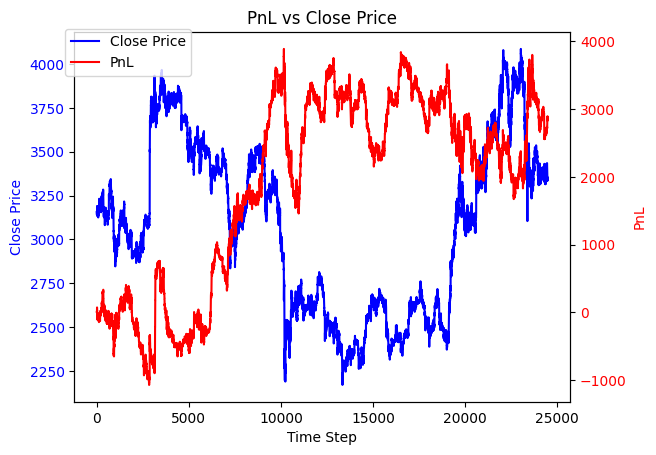

In [60]:
import matplotlib.pyplot as plt
# import numpy as np
# import random
# import torch

# # Fix randomness
# seed = 42
# np.random.seed(seed)
# random.seed(seed)
# torch.manual_seed(seed)
# test_env.seed(seed)
# test_env.action_space.seed(seed)

# Load trained model
model = PPO.load("crypto_trading_ppo")

# Reset environment
obs = test_env.reset()
total_pnl = 0

# Store results for plotting
closing_prices = []
pnl_values = []

# Testing Loop
for _ in range(len(test_df) - 1):
    action, _states = model.predict(obs)
    obs, reward, done, _ = test_env.step(action)
    
    # Track cumulative PnL
    total_pnl += reward
    closing_prices.append(test_df.iloc[test_env.current_step]['Close'])
    pnl_values.append(total_pnl)

    if done:
        break

# Plot PnL vs Close Price
plt.figure(figsize=(12, 6))
fig, ax1 = plt.subplots()

# Plot Closing Price
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Close Price', color='blue')
ax1.plot(closing_prices, color='blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis for PnL
ax2 = ax1.twinx()
ax2.set_ylabel('PnL', color='red')
ax2.plot(pnl_values, color='red', label='PnL')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

# Title
plt.title('PnL vs Close Price')
plt.show()